In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import log_loss

In [2]:
# Specify the path to your Microsoft CSV file
file_path = r'C:\Users\pamar_1wl3que\Documents\blender task 2\titanic.csv'
# Read the CSV file
# Use appropriate encoding and delimiter if necessary
data = pd.read_csv(file_path, encoding='ISO-8859-1', sep=',')  # Adjust 'sep' if needed
# Display the first few rows
print(data.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [3]:
# Preprocess the data
data['Age'].fillna(data['Age'].median(), inplace=True)
data.drop(columns=['Name','PassengerId','Ticket','Cabin'], inplace=True)
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

# One-hot encode categorical variables
data = pd.get_dummies(data, drop_first=True)

# Compute correlation matrix
correlation_matrix = data.corr()
target_corr = correlation_matrix["Survived"].drop("Survived")
print("Correlation of each feature with Survived:")
print(target_corr)

# Select features based on correlation threshold
selected_features = target_corr[abs(target_corr) > 0.0005].index.tolist()
print("\nSelected Features for Model Based on Correlation Threshold:", selected_features)

# Define features and target variable with selected features
X = data[selected_features].values
y = data['Survived'].values

Correlation of each feature with Survived:
Pclass       -0.338481
Age          -0.064910
SibSp        -0.035322
Parch         0.081629
Fare          0.257307
Sex_male     -0.543351
Embarked_Q    0.003650
Embarked_S   -0.149683
Name: Survived, dtype: float64

Selected Features for Model Based on Correlation Threshold: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male', 'Embarked_Q', 'Embarked_S']


C:\Users\pamar_1wl3que\AppData\Local\Temp\ipykernel_26252\2839834285.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Age'].fillna(data['Age'].median(), inplace=True)
C:\Users\pamar_1wl3que\AppData\Local\Temp\ipykernel_26252\2839834285.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

In [4]:
# Split data into training and testing sets
np.random.seed(42)
indices = np.random.permutation(len(X))
train_size = int(len(X) * 0.8)
train_indices, test_indices = indices[:train_size], indices[train_size:]
X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

X_train = X_train.astype(np.float64)
y_train = y_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_test = y_test.astype(np.float64)


In [5]:
# Logistic Regression model class with predict_proba
class LogisticRegressionModel:
    def __init__(self, learning_rate, num_iterations):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None
        self.loss_history = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def compute_loss(self, y, y_pred):
        return -np.mean(y * np.log(y_pred + 1e-15) + (1 - y) * np.log(1 - y_pred + 1e-15))

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0

        for i in range(self.num_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(linear_model)

            # Calculate loss and store it
            loss = self.compute_loss(y, y_pred)
            self.loss_history.append(loss)

            # Calculate gradients
            dw = (1 / num_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / num_samples) * np.sum(y_pred - y)

            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_pred = self.sigmoid(linear_model)
        return np.column_stack((1 - y_pred, y_pred))

    def predict(self, X):
        y_pred_prob = self.predict_proba(X)[:, 1]
        return [1 if i > 0.5 else 0 for i in y_pred_prob]



In [6]:
# Initialize and train the logistic regression model
model = LogisticRegressionModel(learning_rate=0.004, num_iterations=10000)
model.fit(X_train, y_train)

# Generate predictions
y_pred = model.predict(X_test)



Confusion Matrix:
[[103  11]
 [ 22  43]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.90      0.86       114
         1.0       0.80      0.66      0.72        65

    accuracy                           0.82       179
   macro avg       0.81      0.78      0.79       179
weighted avg       0.81      0.82      0.81       179


Accuracy: 0.8156424581005587


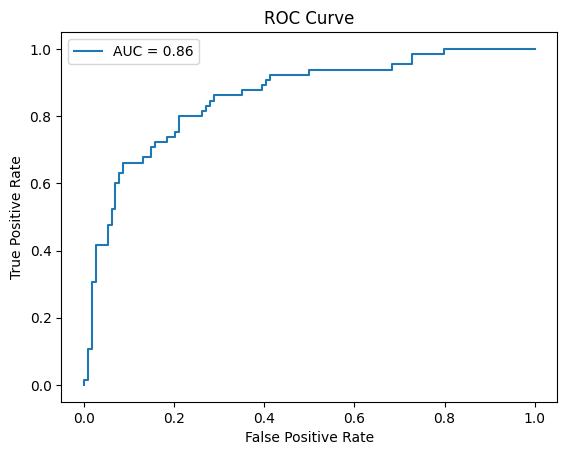

Log Loss: 0.4758434090069914


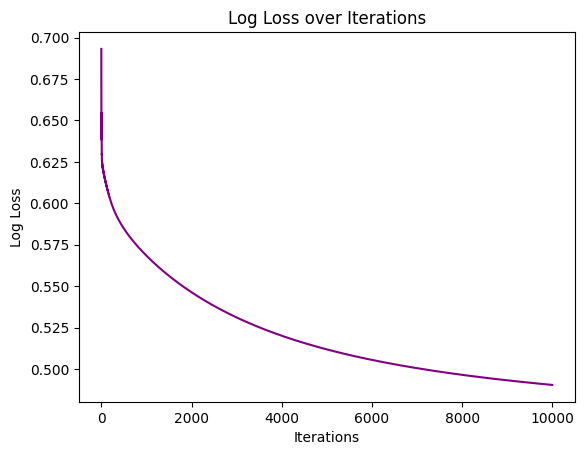

In [7]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy:", accuracy)

# Predict probabilities
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label="AUC = {:.2f}".format(auc_score))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Log loss
log_loss_value = log_loss(y_test, y_pred_prob)
print("Log Loss:", log_loss_value)

# Plot log loss over iterations
plt.figure()
plt.plot(range(model.num_iterations), model.loss_history, color='purple')
plt.xlabel("Iterations")
plt.ylabel("Log Loss")
plt.title("Log Loss over Iterations")
plt.show()
